In [25]:
from transpile_benchy.interface import QASMBench

qasm_bench = QASMBench(size="small")

from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(4, 5)

from virtual_swap.pass_managers import SabreCNSV2, SabreQiskit

In [26]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    transpilers=[SabreCNSV2(coupling_map), SabreQiskit(coupling_map)],
    submodules=[qasm_bench],
    metrics=[depth_metric],
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...
Running circuits for QASMBench:   3%|▎         | 1/38 [00:00<00:09,  3.74it/s]

Accepted CNS subs 6
Accepted CNS subs 1


Running circuits for QASMBench:   8%|▊         | 3/38 [00:00<00:06,  5.47it/s]

Accepted CNS subs 0
Accepted CNS subs 2


Running circuits for QASMBench:  13%|█▎        | 5/38 [00:00<00:05,  5.53it/s]

Accepted CNS subs 0


Running circuits for QASMBench:  16%|█▌        | 6/38 [00:01<00:06,  4.86it/s]

Accepted CNS subs 0
Accepted CNS subs 8


Running circuits for QASMBench:  21%|██        | 8/38 [00:02<00:10,  2.81it/s]

Accepted CNS subs 0


Running circuits for QASMBench:  24%|██▎       | 9/38 [00:02<00:11,  2.54it/s]

Accepted CNS subs 0


Running circuits for QASMBench:  29%|██▉       | 11/38 [00:03<00:09,  2.84it/s]

Accepted CNS subs 0
Accepted CNS subs 0


Running circuits for QASMBench:  34%|███▍      | 13/38 [00:03<00:07,  3.45it/s]

Accepted CNS subs 4
Accepted CNS subs 13


Running circuits for QASMBench:  39%|███▉      | 15/38 [00:04<00:07,  3.03it/s]

Accepted CNS subs 0
array must not contain infs or NaNs
Accepted CNS subs 0


Running circuits for QASMBench:  42%|████▏     | 16/38 [00:06<00:18,  1.17it/s]

array must not contain infs or NaNs
Accepted CNS subs 0


Running circuits for QASMBench:  47%|████▋     | 18/38 [00:07<00:13,  1.50it/s]

Accepted CNS subs 0


Running circuits for QASMBench:  53%|█████▎    | 20/38 [00:08<00:09,  2.00it/s]

Accepted CNS subs 0
Accepted CNS subs 0


Running circuits for QASMBench:  61%|██████    | 23/38 [00:08<00:03,  3.76it/s]

Accepted CNS subs 0
Accepted CNS subs 0


Running circuits for QASMBench:  63%|██████▎   | 24/38 [00:09<00:03,  4.62it/s]

Accepted CNS subs 0
Accepted CNS subs 3


Running circuits for QASMBench:  68%|██████▊   | 26/38 [00:09<00:02,  4.98it/s]

Accepted CNS subs 1
Accepted CNS subs 39


Running circuits for QASMBench:  71%|███████   | 27/38 [00:10<00:06,  1.65it/s]

Accepted CNS subs 16


Running circuits for QASMBench:  76%|███████▋  | 29/38 [01:06<02:31, 16.86s/it]

Accepted CNS subs 13


Running circuits for QASMBench:  79%|███████▉  | 30/38 [01:07<01:36, 12.11s/it]

Accepted CNS subs 26


Running circuits for QASMBench:  84%|████████▍ | 32/38 [01:11<00:40,  6.81s/it]

Accepted CNS subs 1
Accepted CNS subs 0


Running circuits for QASMBench:  89%|████████▉ | 34/38 [01:12<00:13,  3.46s/it]

Accepted CNS subs 4
Accepted CNS subs 0


Running circuits for QASMBench:  92%|█████████▏| 35/38 [01:12<00:07,  2.46s/it]

Accepted CNS subs 7


Running circuits for QASMBench:  97%|█████████▋| 37/38 [01:13<00:01,  1.36s/it]

Accepted CNS subs 0


Running circuits for QASMBench: 100%|██████████| 38/38 [01:13<00:00,  1.93s/it]

Accepted CNS subs 8


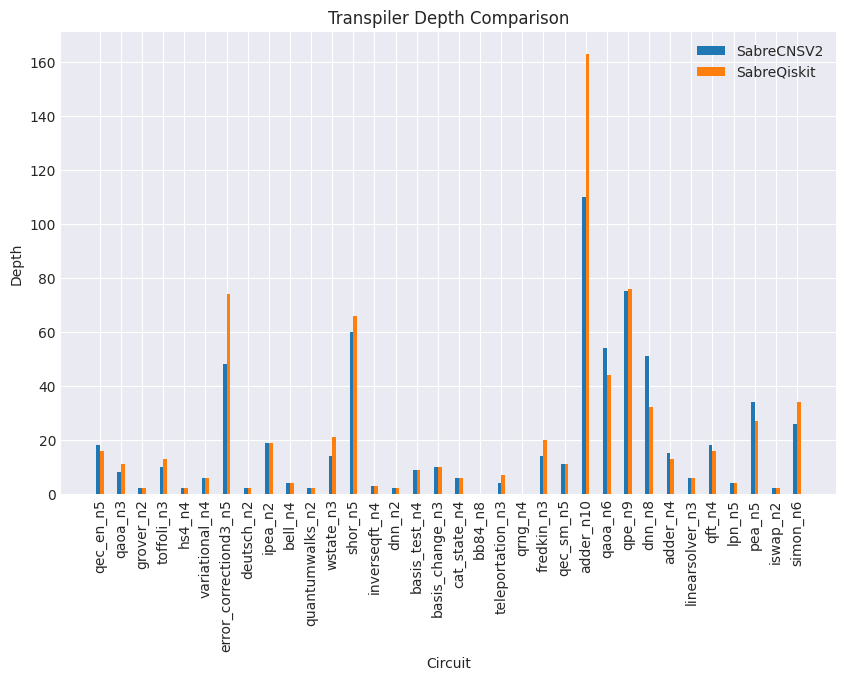

In [27]:
benchmark.plot()